# Importing the Training data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data
!unzip '/content/drive/MyDrive/AML/Places2_simp.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Places2_simp/phone_booth/00000414.jpg  
  inflating: Places2_simp/phone_booth/00000399.jpg  
  inflating: Places2_simp/phone_booth/00000158.jpg  
  inflating: Places2_simp/phone_booth/00000164.jpg  
  inflating: Places2_simp/phone_booth/00000602.jpg  
  inflating: Places2_simp/phone_booth/00000616.jpg  
  inflating: Places2_simp/phone_booth/00000170.jpg  
  inflating: Places2_simp/phone_booth/00000825.jpg  
  inflating: Places2_simp/phone_booth/00000831.jpg  
  inflating: Places2_simp/phone_booth/00000819.jpg  
  inflating: Places2_simp/phone_booth/00000992.jpg  
  inflating: Places2_simp/phone_booth/00000986.jpg  
  inflating: Places2_simp/phone_booth/00000038.jpg  
  inflating: Places2_simp/phone_booth/00000010.jpg  
  inflating: Places2_simp/phone_booth/00000776.jpg  
  inflating: Places2_simp/phone_booth/00000762.jpg  
  inflating: Places2_simp/phone_booth/00000004.jpg  
  inflating: Places2_simp/phone_booth/00000789.j

In [ ]:
!unzip '/content/drive/MyDrive/AML/test.zip'

Archive:  /content/drive/MyDrive/AML/test.zip
   creating: test/
   creating: test/airport_terminal/
  inflating: test/airport_terminal/2000x1125-terminal-5-t5-heathrow-airportc-david-j-osborn.jpg  
  inflating: test/airport_terminal/28f195d0-8f10-11e8-b6b0-0242ac110007.jpg  
  inflating: test/airport_terminal/2_JS264501658.jpg  
  inflating: test/airport_terminal/8eec424e19869185009a80261e583b33Y29udGVudHNlYXJjaGFwaSwxNjc2MzYxODk0-2.70430304.jpg  
  inflating: test/airport_terminal/blog-heathrow1_Belinda_Fewings_for_Unsplash.jpg  
   creating: test/amphitheatre/
  inflating: test/amphitheatre/aerial-view-of-the-al-dana-amphitheatre-in-bahrain-showing-stage-seating-and-entrance-circulation.jpg  
  inflating: test/amphitheatre/Arles_-_2017-05-24_-_Roman_Amphitheatre_-_3804.jpg  
  inflating: test/amphitheatre/Gallo_Roman_Amphitheater.jpg  
  inflating: test/amphitheatre/h.jpg  
  inflating: test/amphitheatre/photo-1576113672860-33dcbde3b543.jpg  
   creating: test/amuesment_park/
  infl

In [ ]:
import numpy as np
import pandas as pd
import os

import torch 
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm  
from time import time

from torchvision.utils import make_grid
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, Resize, Normalize, ColorJitter, GaussianBlur, RandomAffine, RandomHorizontalFlip , RandomRotation

from torch.utils.tensorboard import SummaryWriter

import glob
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
SEED = 100

def set_seed(seed: int):
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

renaming the test file names for better accessiblity as it contained some special characters 


In [ ]:
TEST_DIR = '/content/test/'
count = 1
for i in os.listdir(TEST_DIR):
  dir = os.path.join(TEST_DIR, i)
  for j in os.listdir(dir) :
    os.rename(os.path.join(dir, j) , os.path.join(dir ,f"{str(count)}.jpg") )
    count += 1 

creating a list of all the images in the sets

In [ ]:
train_val_images = glob.glob("/content/Places2_simp/*/*")
test_images = glob.glob("/content/test/*/*")

## Train & Tests Split

Train:80% 

test:20%

In [ ]:
def train_val_split(images_list, train_size):
  n = int(len(images_list) * train_size)
  train_list = images_list[n:]
  val_list = images_list[:n]
  return train_list, val_list

random.shuffle(train_val_images)
train_images, val_images = train_val_split(train_val_images, 0.2)
print(len(train_images), len(val_images))

32000 8000


## defining the transforms for each train, test, validation

In [ ]:
mean , std = [0.4548, 0.4339, 0.4014], [0.2271, 0.2240, 0.2320]

train_transform = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(p = 0.8),
    RandomAffine(degrees=(0, 20), translate=(0.1, 0.2), scale=(0.75, 0.85)),
    ToTensor(),
    Normalize( mean, std)
])

test_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean, std)
])

## Labels


In [ ]:
target_names = [st.split("/")[-1] for st in glob.glob("/content/Places2_simp/*")]
target_names.sort()
target_names

['airport_terminal',
 'amphitheatre',
 'amusement_park',
 'art_gallery',
 'bakery_shop',
 'bar',
 'bookstore',
 'botanical_garden',
 'bridge',
 'bus_interior',
 'butchers_shop',
 'campsite',
 'classroom',
 'coffee_shop',
 'construction_site',
 'courtyard',
 'driveway',
 'fire_station',
 'fountain',
 'gas_station',
 'harbour',
 'highway',
 'kindergarten_classroom',
 'lobby',
 'market_outdoor',
 'museum',
 'office',
 'parking_lot',
 'phone_booth',
 'playground',
 'railroad_track',
 'restaurant',
 'river',
 'shed',
 'staircase',
 'supermarket',
 'swimming_pool_outdoor',
 'track',
 'valley',
 'yard']

In [ ]:
len(target_names)

40

creating the dictionary to map the labels.

In [ ]:
target_2_int = {}
counter = 0
for _ in target_names:
    target_2_int[_] = counter
    counter += 1

target_2_int

{'airport_terminal': 0,
 'amphitheatre': 1,
 'amusement_park': 2,
 'art_gallery': 3,
 'bakery_shop': 4,
 'bar': 5,
 'bookstore': 6,
 'botanical_garden': 7,
 'bridge': 8,
 'bus_interior': 9,
 'butchers_shop': 10,
 'campsite': 11,
 'classroom': 12,
 'coffee_shop': 13,
 'construction_site': 14,
 'courtyard': 15,
 'driveway': 16,
 'fire_station': 17,
 'fountain': 18,
 'gas_station': 19,
 'harbour': 20,
 'highway': 21,
 'kindergarten_classroom': 22,
 'lobby': 23,
 'market_outdoor': 24,
 'museum': 25,
 'office': 26,
 'parking_lot': 27,
 'phone_booth': 28,
 'playground': 29,
 'railroad_track': 30,
 'restaurant': 31,
 'river': 32,
 'shed': 33,
 'staircase': 34,
 'supermarket': 35,
 'swimming_pool_outdoor': 36,
 'track': 37,
 'valley': 38,
 'yard': 39}

In [ ]:
int_2_target = {i:t for t, i in target_2_int.items()}
int_2_target

{0: 'airport_terminal',
 1: 'amphitheatre',
 2: 'amusement_park',
 3: 'art_gallery',
 4: 'bakery_shop',
 5: 'bar',
 6: 'bookstore',
 7: 'botanical_garden',
 8: 'bridge',
 9: 'bus_interior',
 10: 'butchers_shop',
 11: 'campsite',
 12: 'classroom',
 13: 'coffee_shop',
 14: 'construction_site',
 15: 'courtyard',
 16: 'driveway',
 17: 'fire_station',
 18: 'fountain',
 19: 'gas_station',
 20: 'harbour',
 21: 'highway',
 22: 'kindergarten_classroom',
 23: 'lobby',
 24: 'market_outdoor',
 25: 'museum',
 26: 'office',
 27: 'parking_lot',
 28: 'phone_booth',
 29: 'playground',
 30: 'railroad_track',
 31: 'restaurant',
 32: 'river',
 33: 'shed',
 34: 'staircase',
 35: 'supermarket',
 36: 'swimming_pool_outdoor',
 37: 'track',
 38: 'valley',
 39: 'yard'}

## Data Class

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, train=True):
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = img_path.split("/")[-2]
            label = target_2_int[label]
        else:
            label = img_path.split("/")[-1].split(".")[0]
        label = int(label)
        return image, label

## Dataset & DataLoader

In [ ]:
test_images

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
training_data = ImageDataset(train_images, train_transform, train=True)
val_data = ImageDataset(val_images, test_transform, train=True)
test_data = ImageFolder(TEST_DIR, test_transform)

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
for x, y in train_dataloader:
    print(x.shape)
    print(y)
    break

torch.Size([32, 3, 224, 224])
tensor([ 6, 18,  7,  9,  4, 36, 16,  0, 24,  8, 10, 38, 23,  7,  7,  2,  3, 33,
        10, 32,  3, 10, 22, 12, 12, 26,  5, 37, 27,  6,  9,  6])


## Visualising the transformed images 

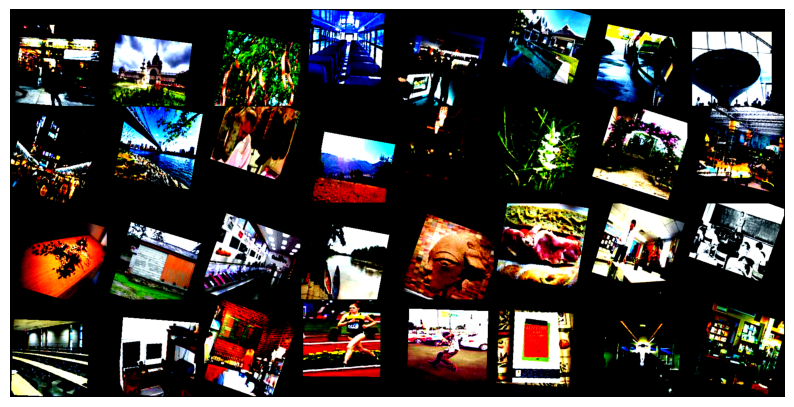

In [ ]:
fig = plt.figure(figsize=(10,10))
img = make_grid(next(iter(train_dataloader))[0], nrow=8)
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.axis("off")
plt.show()

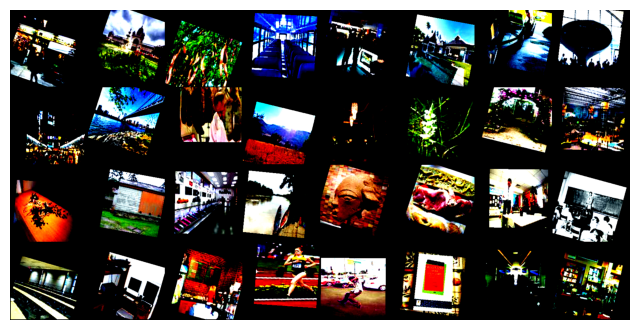

In [ ]:
fig = plt.figure(figsize=(8, 8))
img = make_grid(next(iter(train_dataloader))[0], nrow=8)
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.axis("off")
plt.show()

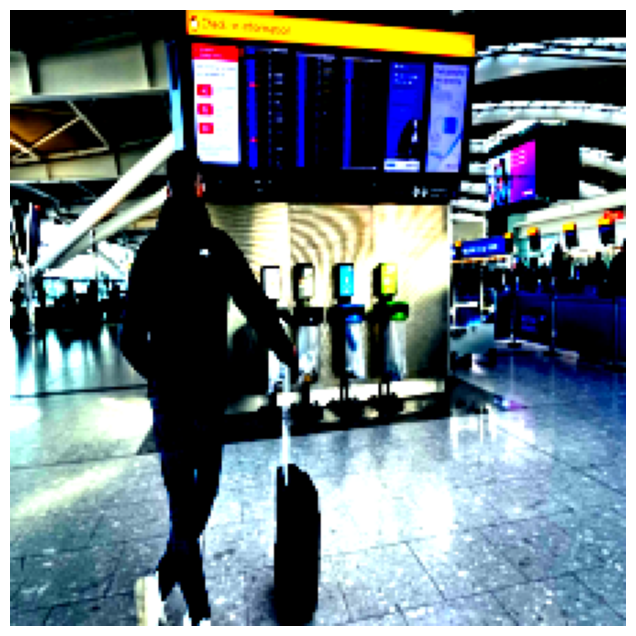

In [ ]:
fig = plt.figure(figsize=(8,8))
img = make_grid(next(iter(test_loader))[0], nrow=8)
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available()else "cpu"
print(f"Using {device} device")

Using cuda device


# Define Train Model

In [ ]:
from torchvision import models
import torch

In [ ]:
import torch.nn as nn
import torchvision

model = torchvision.models.resnet34(pretrained=True)
model.fc =  nn.Linear(in_features=512, out_features=40)
model = model.to(device)

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

defining the optimisers and loss functions

In [ ]:
from torch.optim.adam import Adam
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()
MODEL_PATH = '/content/drive/MyDrive/AML/models/model' 

In [ ]:
LEN_TRAIN = 32000
LEN_TEST = 8000

# Experiment 1

Parameters: 

Batch_size: 32​

Epochs: 50​

Learning rate: 0.0003​



## Training

In [ ]:
train_writer = SummaryWriter('/content/drive/MyDrive/AML/runs/resnet34_train_')
val_writer = SummaryWriter('/content/drive/MyDrive/AML/runs/resnet34_test_')

for epoch in range(35, 50):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in val_dataloader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    
    end = time()
    duration = (end - start) / 60
    train_writer.add_scalar('training_loss' , ep_tr_acc, global_step = epoch)
    val_writer.add_scalar('val_loss' , ep_test_acc, global_step = epoch)

    if epoch % 5 ==0:
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimiser.state_dict(),
              'loss': loss,
              }, f'{MODEL_PATH}_{epoch}.pth')
    
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {ep_test_acc}")

100%|██████████| 1000/1000 [02:48<00:00,  5.92batch/s]


Epoch: 35, Time: 3.295927671591441, Loss: 0.08539315313100815
Train_acc: 0.9344375, Test_acc: 0.514375


100%|██████████| 1000/1000 [02:38<00:00,  6.29batch/s]


Epoch: 36, Time: 3.1204315106074016, Loss: 0.0651373341679573
Train_acc: 0.936125, Test_acc: 0.5135


100%|██████████| 1000/1000 [02:37<00:00,  6.34batch/s]


Epoch: 37, Time: 3.0988303979237872, Loss: 0.09468581527471542
Train_acc: 0.93803125, Test_acc: 0.513375


100%|██████████| 1000/1000 [02:38<00:00,  6.32batch/s]


Epoch: 38, Time: 3.101703159014384, Loss: 0.06436755508184433
Train_acc: 0.93546875, Test_acc: 0.514625


100%|██████████| 1000/1000 [02:37<00:00,  6.36batch/s]


Epoch: 39, Time: 3.0951690435409547, Loss: 0.09266821295022964
Train_acc: 0.9360625, Test_acc: 0.513375


100%|██████████| 1000/1000 [02:38<00:00,  6.32batch/s]


Epoch: 40, Time: 3.1195316116015115, Loss: 0.18692363798618317
Train_acc: 0.93734375, Test_acc: 0.512875


100%|██████████| 1000/1000 [02:40<00:00,  6.24batch/s]


Epoch: 41, Time: 3.1416060884793597, Loss: 0.07486623525619507
Train_acc: 0.93490625, Test_acc: 0.514


100%|██████████| 1000/1000 [02:38<00:00,  6.31batch/s]


Epoch: 42, Time: 3.1098252336184182, Loss: 0.1402575820684433
Train_acc: 0.933, Test_acc: 0.514


100%|██████████| 1000/1000 [02:38<00:00,  6.31batch/s]


Epoch: 43, Time: 3.109054120381673, Loss: 0.07991231232881546
Train_acc: 0.93496875, Test_acc: 0.51275


100%|██████████| 1000/1000 [02:37<00:00,  6.35batch/s]


Epoch: 44, Time: 3.093298939863841, Loss: 0.08658639341592789
Train_acc: 0.93540625, Test_acc: 0.513375


100%|██████████| 1000/1000 [02:38<00:00,  6.33batch/s]


Epoch: 45, Time: 3.1005956133206687, Loss: 0.2583414316177368
Train_acc: 0.93565625, Test_acc: 0.512375


100%|██████████| 1000/1000 [02:37<00:00,  6.33batch/s]


Epoch: 46, Time: 3.1024526317914325, Loss: 0.06351906806230545
Train_acc: 0.93415625, Test_acc: 0.5145


100%|██████████| 1000/1000 [02:37<00:00,  6.34batch/s]


Epoch: 47, Time: 3.097520371278127, Loss: 0.1324470341205597
Train_acc: 0.9365, Test_acc: 0.513625


100%|██████████| 1000/1000 [02:37<00:00,  6.33batch/s]


Epoch: 48, Time: 3.098530638217926, Loss: 0.0820377841591835
Train_acc: 0.93546875, Test_acc: 0.514


100%|██████████| 1000/1000 [02:36<00:00,  6.38batch/s]


Epoch: 49, Time: 3.077423119544983, Loss: 0.041865572333335876
Train_acc: 0.93571875, Test_acc: 0.513625


In [ ]:
torch.save(model,'/content/drive/MyDrive/AML/models/final_model.pth')

saved checkpoints for every 5 epochs

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/AML/models/model_45.pth')
checkpoint
# model
model.load_state_dict(checkpoint['model_state_dict'])
optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# model.eval()
# - or -
# model.train()

loading the model trained for 50 epochs

In [ ]:
model = torch.load('/content/drive/MyDrive/AML/models/final_model.pth')

In [ ]:
test_label = np.zeros((len(test_loader.dataset,)), dtype=object)
test_id = np.zeros((len(test_loader.dataset,)), dtype=object)

y_true = np.zeros((len(test_loader.dataset,)), dtype=object)

for i, (X, y) in enumerate(test_loader):
    X = X.to(device)
    y = y.to(device)
    model.eval()
    pred = model(X)

    test_label[i] = torch.argmax(pred, dim=1).item()
    y_true[i] = y.item()

test_label = test_label.tolist()
y_true = y_true.tolist() 

## Evaluation

In [ ]:
def top_k_acc(k):
  
  top_5_correct = 0
  total_samples = 0

  for i, (X, y) in enumerate(test_loader):
    X = X.to(device)
    y = y.to(device)
    model.eval()
    pred = model(X)
    
    _, predicted = torch.topk(pred, k=k, dim=1)        
    # Check if the true labels are in the top 5 predictions
    top_5_correct += (predicted == y.view(-1, 1)).sum().item()
    total_samples += y.size(0)

  top_5_accuracy = (top_5_correct / total_samples) * 100
  return (top_5_accuracy)

Top k-accuracy on the test dataset

In [ ]:
print('Top 1 accuracy:' , top_k_acc(1))
print('Top 2 accuracy:' , top_k_acc(2))
print('Top 5 accuracy:' , top_k_acc(5))
print('Top 10 accuracy:' , top_k_acc(10))


Top 1 accuracy: 67.5
Top 2 accuracy: 78.0
Top 5 accuracy: 90.5
Top 10 accuracy: 94.0


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/AML/runs/

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cf_matrix = confusion_matrix(y_true, test_label)

In [ ]:
class_names = target_names

# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

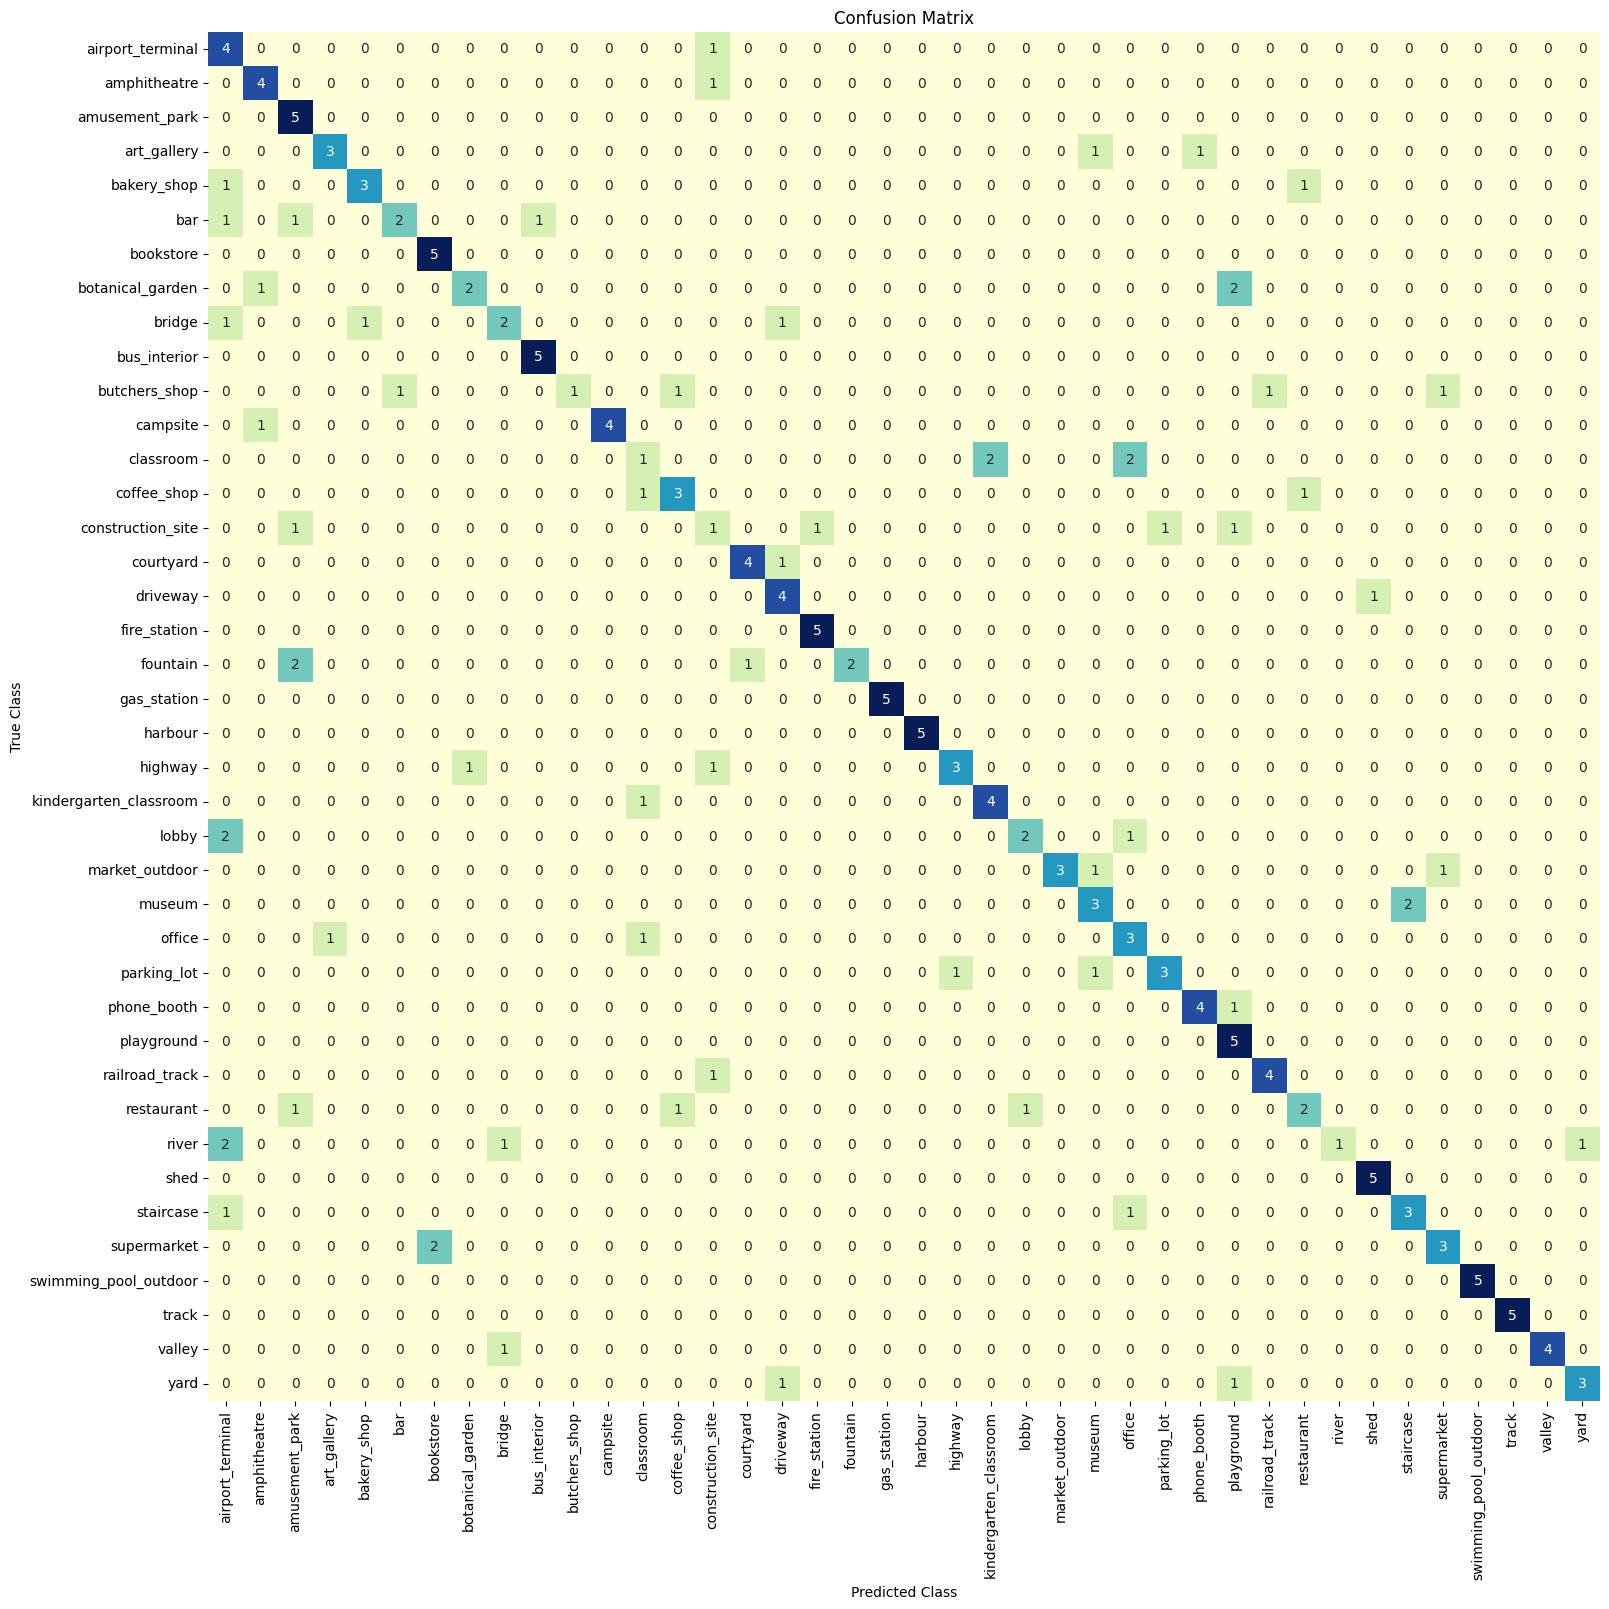

In [ ]:
plt.figure(figsize=(16,16))

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
from sklearn.metrics import classification_report 

In [ ]:
print(classification_report(y_true, test_label,target_names= target_names))

                        precision    recall  f1-score   support

      airport_terminal       0.33      0.80      0.47         5
          amphitheatre       0.67      0.80      0.73         5
        amusement_park       0.50      1.00      0.67         5
           art_gallery       0.75      0.60      0.67         5
           bakery_shop       0.75      0.60      0.67         5
                   bar       0.67      0.40      0.50         5
             bookstore       0.71      1.00      0.83         5
      botanical_garden       0.67      0.40      0.50         5
                bridge       0.50      0.40      0.44         5
          bus_interior       0.83      1.00      0.91         5
         butchers_shop       1.00      0.20      0.33         5
              campsite       1.00      0.80      0.89         5
             classroom       0.25      0.20      0.22         5
           coffee_shop       0.60      0.60      0.60         5
     construction_site       0.20      

## GRADCAM


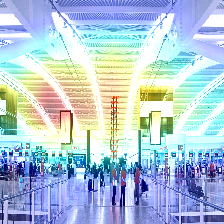

In [ ]:
import torch
from torch.autograd import Function
import numpy as np
import cv2
from torchvision import models, transforms
from google.colab.patches import cv2_imshow

# Define the GradCAM class
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.feature_maps = None
        self.gradient = None
        self.model.eval()

        # Register the hook to save the feature maps and gradients
        self.model.layer4.register_forward_hook(self.save_feature_maps)
        self.model.layer4.register_backward_hook(self.save_gradient)

    def save_feature_maps(self, module, input, output):
        self.feature_maps = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

    def forward(self, x):
        return self.model(x)

    def backward(self, output, target_class):
        self.model.zero_grad()

        # Compute the gradients
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        if torch.cuda.is_available():
            one_hot = one_hot.cuda()  # Move to GPU if available
        output.backward(gradient=one_hot, retain_graph=True)

    def generate_cam(self):
        weights = torch.mean(self.gradient, dim=(2, 3)).squeeze()
        cam = torch.zeros(self.feature_maps.shape[2:], dtype=torch.float32)
        if torch.cuda.is_available():
            cam = cam.cuda()  # Move to GPU if available

        for i, w in enumerate(weights):
            cam += w * self.feature_maps[0][i, :, :]

        cam = np.maximum(cam.detach().cpu().numpy(), 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


# Load pre-trained ResNet-34
model = models.resnet34(pretrained=True)
if torch.cuda.is_available():
    model = model.cuda()  # Move model to GPU if available

# Instantiate GradCAM
grad_cam = GradCAM(model)

# Load and preprocess the image
image_path = '/content/test/airport_terminal/2000x1125-terminal-5-t5-heathrow-airportc-david-j-osborn.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image_tensor = transforms.ToTensor()(image).unsqueeze(0)
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()  # Move input tensor to GPU if available

# Perform forward and backward passes
output = grad_cam.forward(image_tensor)
target_class = torch.argmax(output, dim=1).item()
grad_cam.backward(output, target_class)

# Generate the Grad-CAM
cam = grad_cam.generate_cam()

# Superimpose the Grad-CAM on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + image

# Display the result
cv2_imshow(superimposed_img)

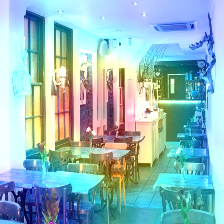

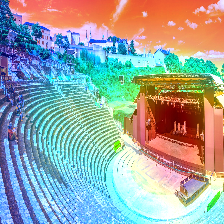

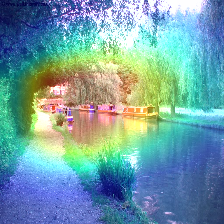

# Experiment 2

Parameters:

Batch size: 64​

Epochs: 20​

learning rate: 0.0001​



In [ ]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

In [ ]:
from torch.optim import Adam
loss_fn = nn.CrossEntropyLoss()
optimiser = Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)
model = model.to(device)

In [ ]:
for epoch in range(20):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    
    end = time()
    duration = (end - start) / 60
    
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {ep_test_acc}")

100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 0, Time: 3.5048345923423767, Loss: 0.38042259216308594
Train_acc: 0.889425, Test_acc: 0.5050505050505051


100%|██████████| 625/625 [03:19<00:00,  3.14batch/s]


Epoch: 1, Time: 3.5206682960192364, Loss: 0.06848844885826111
Train_acc: 0.975625, Test_acc: 0.4797979797979798


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 2, Time: 3.5106894771258035, Loss: 0.04792725294828415
Train_acc: 0.99035, Test_acc: 0.5454545454545454


100%|██████████| 625/625 [03:19<00:00,  3.14batch/s]


Epoch: 3, Time: 3.522047460079193, Loss: 0.14968182146549225
Train_acc: 0.987175, Test_acc: 0.5656565656565656


100%|██████████| 625/625 [03:19<00:00,  3.14batch/s]


Epoch: 4, Time: 3.517109803358714, Loss: 0.11083384603261948
Train_acc: 0.9815, Test_acc: 0.4090909090909091


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 5, Time: 3.5088792045911155, Loss: 0.01604299061000347
Train_acc: 0.9874, Test_acc: 0.4898989898989899


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 6, Time: 3.509942388534546, Loss: 0.043395884335041046
Train_acc: 0.98965, Test_acc: 0.5404040404040404


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 7, Time: 3.5104671001434324, Loss: 0.06668324768543243
Train_acc: 0.985475, Test_acc: 0.5353535353535354


100%|██████████| 625/625 [03:18<00:00,  3.14batch/s]


Epoch: 8, Time: 3.518349905808767, Loss: 0.08982434868812561
Train_acc: 0.9858, Test_acc: 0.48484848484848486


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 9, Time: 3.506464986006419, Loss: 0.0646054595708847
Train_acc: 0.987975, Test_acc: 0.48484848484848486


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 10, Time: 3.507439831892649, Loss: 0.15138867497444153
Train_acc: 0.990425, Test_acc: 0.4494949494949495


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 11, Time: 3.5060242374738055, Loss: 0.01251740287989378
Train_acc: 0.9891, Test_acc: 0.47474747474747475


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 12, Time: 3.5073180238405866, Loss: 0.05948265641927719
Train_acc: 0.986425, Test_acc: 0.5


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 13, Time: 3.5178190151850384, Loss: 0.20595204830169678
Train_acc: 0.9857, Test_acc: 0.48484848484848486


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 14, Time: 3.5110817273457844, Loss: 0.0590662881731987
Train_acc: 0.98935, Test_acc: 0.4292929292929293


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 15, Time: 3.5147612770398458, Loss: 0.09134086221456528
Train_acc: 0.993525, Test_acc: 0.5050505050505051


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 16, Time: 3.5165907303492228, Loss: 0.06584782153367996
Train_acc: 0.98605, Test_acc: 0.4898989898989899


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 17, Time: 3.522047734260559, Loss: 0.11752715706825256
Train_acc: 0.9878, Test_acc: 0.47474747474747475


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 18, Time: 3.5133110920588178, Loss: 0.036430034786462784
Train_acc: 0.991875, Test_acc: 0.51010101010101


100%|██████████| 625/625 [03:18<00:00,  3.15batch/s]


Epoch: 19, Time: 3.511802156766256, Loss: 0.06679725646972656
Train_acc: 0.990725, Test_acc: 0.5454545454545454


In [ ]:
print('Top 1 accuracy:' , top_k_acc(1))
print('Top 2 accuracy:' , top_k_acc(2))
print('Top 5 accuracy:' , top_k_acc(5))
print('Top 10 accuracy:' , top_k_acc(10))

Top 1 accuracy: 54.54545454545454
Top 2 accuracy: 68.68686868686868
Top 5 accuracy: 83.33333333333334
Top 10 accuracy: 90.9090909090909


# Experiment 3

Parameters:

Batch_size = 64​

Epochs = 60​

Learning rate = 0.003​



In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)

In [ ]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
from torch.optim.adam import Adam
optimiser = Adam(model.parameters(), lr=0.003, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()
MODEL_PATH = '/content/drive/MyDrive/AML_Coursework/models/model' 

In [ ]:
LEN_TRAIN = 32000
LEN_TEST = 8000

The model was trained for 60 epochs in two iterations i.e. first it trained for epochs 1 to 30 then 31st epoch to 60 epochs

In [ ]:
train_writer = SummaryWriter('runs/resnet34_train_30')
val_writer = SummaryWriter('runs/resnet34_test_30')

for epoch in range(31,60):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in val_dataloader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    
    end = time()
    duration = (end - start) / 60
    train_writer.add_scalar('training_loss' , ep_tr_acc, global_step = epoch)
    val_writer.add_scalar('val_loss' , ep_test_acc, global_step = epoch)

    if epoch % 5 ==0:
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimiser.state_dict(),
              'loss': loss,
              }, f'{MODEL_PATH}_{epoch}.pth')
    
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {ep_test_acc}")

100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 31, Time: 2.969029637177785, Loss: 1.489914059638977
Train_acc: 0.48703125, Test_acc: 0.401125


100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 32, Time: 2.975638131300608, Loss: 1.5625426769256592
Train_acc: 0.49175, Test_acc: 0.400125


100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 33, Time: 2.96428560813268, Loss: 1.5883936882019043
Train_acc: 0.49071875, Test_acc: 0.399875


100%|██████████| 500/500 [02:29<00:00,  3.35batch/s]


Epoch: 34, Time: 2.9521756251653035, Loss: 1.590098261833191
Train_acc: 0.48853125, Test_acc: 0.399875


100%|██████████| 500/500 [02:28<00:00,  3.36batch/s]


Epoch: 35, Time: 2.952810076872508, Loss: 1.5375500917434692
Train_acc: 0.4898125, Test_acc: 0.40075


100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 36, Time: 2.963827308019002, Loss: 1.4817684888839722
Train_acc: 0.48825, Test_acc: 0.4015


100%|██████████| 500/500 [02:28<00:00,  3.36batch/s]


Epoch: 37, Time: 2.9671021183331807, Loss: 1.593409776687622
Train_acc: 0.489375, Test_acc: 0.399125


100%|██████████| 500/500 [02:29<00:00,  3.35batch/s]


Epoch: 38, Time: 2.9666173736254375, Loss: 1.4083433151245117
Train_acc: 0.48940625, Test_acc: 0.399875


100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 39, Time: 2.9753849148750304, Loss: 1.539301872253418
Train_acc: 0.4910625, Test_acc: 0.3985


100%|██████████| 500/500 [02:29<00:00,  3.33batch/s]


Epoch: 40, Time: 2.972529641787211, Loss: 1.5653002262115479
Train_acc: 0.4880625, Test_acc: 0.399875


100%|██████████| 500/500 [02:30<00:00,  3.33batch/s]


Epoch: 41, Time: 2.9800517201423644, Loss: 1.4472330808639526
Train_acc: 0.48896875, Test_acc: 0.40125


100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 42, Time: 2.9693113207817077, Loss: 1.5190980434417725
Train_acc: 0.489375, Test_acc: 0.4005


100%|██████████| 500/500 [02:30<00:00,  3.33batch/s]


Epoch: 43, Time: 2.975094215075175, Loss: 1.5534344911575317
Train_acc: 0.49234375, Test_acc: 0.400125


100%|██████████| 500/500 [02:29<00:00,  3.35batch/s]


Epoch: 44, Time: 2.9813773671785992, Loss: 1.520157814025879
Train_acc: 0.48959375, Test_acc: 0.399


100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 45, Time: 2.9671321471532184, Loss: 1.6088541746139526
Train_acc: 0.49109375, Test_acc: 0.401125


100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 46, Time: 2.971826692422231, Loss: 1.494168758392334
Train_acc: 0.49078125, Test_acc: 0.399875


100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 47, Time: 2.966212546825409, Loss: 1.5574320554733276
Train_acc: 0.4883125, Test_acc: 0.400375


100%|██████████| 500/500 [02:29<00:00,  3.35batch/s]


Epoch: 48, Time: 2.960772462685903, Loss: 1.5206388235092163
Train_acc: 0.49075, Test_acc: 0.4015


100%|██████████| 500/500 [02:29<00:00,  3.35batch/s]


Epoch: 49, Time: 2.9563451488812764, Loss: 1.5953898429870605
Train_acc: 0.4915, Test_acc: 0.39975


100%|██████████| 500/500 [02:29<00:00,  3.35batch/s]


Epoch: 50, Time: 2.957863450050354, Loss: 1.599808692932129
Train_acc: 0.48840625, Test_acc: 0.4005


100%|██████████| 500/500 [02:28<00:00,  3.36batch/s]


Epoch: 51, Time: 2.965178732077281, Loss: 1.5286790132522583
Train_acc: 0.49009375, Test_acc: 0.399


100%|██████████| 500/500 [02:28<00:00,  3.36batch/s]


Epoch: 52, Time: 2.9476543704668683, Loss: 1.5482168197631836
Train_acc: 0.48878125, Test_acc: 0.400125


100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 53, Time: 2.9630489150683084, Loss: 1.5555380582809448
Train_acc: 0.48940625, Test_acc: 0.400375


100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 54, Time: 2.965423079331716, Loss: 1.5834213495254517
Train_acc: 0.490375, Test_acc: 0.401125


100%|██████████| 500/500 [02:29<00:00,  3.35batch/s]


Epoch: 55, Time: 2.9570778012275696, Loss: 1.5228856801986694
Train_acc: 0.49209375, Test_acc: 0.399375


100%|██████████| 500/500 [02:29<00:00,  3.34batch/s]


Epoch: 56, Time: 2.9566107908884685, Loss: 1.56296706199646
Train_acc: 0.4874375, Test_acc: 0.4


100%|██████████| 500/500 [02:29<00:00,  3.35batch/s]


Epoch: 57, Time: 2.951213546593984, Loss: 1.5713849067687988
Train_acc: 0.489875, Test_acc: 0.399


100%|██████████| 500/500 [02:28<00:00,  3.37batch/s]


Epoch: 58, Time: 2.947603766123454, Loss: 1.471134901046753
Train_acc: 0.49009375, Test_acc: 0.40075


100%|██████████| 500/500 [02:28<00:00,  3.37batch/s]


Epoch: 59, Time: 2.9360522309939068, Loss: 1.5371538400650024
Train_acc: 0.48859375, Test_acc: 0.400125


In [ ]:
print('Top 1 accuracy:' , top_k_acc(1))
print('Top 2 accuracy:' , top_k_acc(2))
print('Top 5 accuracy:' , top_k_acc(5))
print('Top 10 accuracy:' , top_k_acc(10))